In [1]:
# Step 1: Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning imports
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Network analysis
import networkx as nx

# For better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [2]:
# Step 2: Load and explore the data
df = pd.read_csv("D:\Project 2\CloudWatch_Traffic_Web_Attack - Copy.csv")

print("Data Overview:")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

display(df.head())

df.info()

Data Overview:
Dataset shape: (282, 16)
Columns: ['bytes_in', 'bytes_out', 'creation_time', 'end_time', 'src_ip', 'src_ip_country_code', 'protocol', 'response.code', 'dst_port', 'dst_ip', 'rule_names', 'observation_name', 'source.meta', 'source.name', 'time', 'detection_types']


,bytes_in,bytes_out,creation_time,end_time,src_ip,src_ip_country_code,protocol,response.code,dst_port,dst_ip,rule_names,observation_name,source.meta,source.name,time,detection_types
0,5602,12990,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,147.161.161.82,AE,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
1,30912,18186,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.33.6,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
2,28506,13468,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.212.255,CA,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
3,30546,14278,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,136.226.64.114,US,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule
4,6526,13892,2024-04-25T23:00:00Z,2024-04-25T23:10:00Z,165.225.240.79,NL,HTTPS,200,443,10.138.69.97,Suspicious Web Traffic,Adversary Infrastructure Interaction,AWS_VPC_Flow,prod_webserver,2024-04-25T23:00:00Z,waf_rule


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282 entries, 0 to 281
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   bytes_in             282 non-null    int64 
 1   bytes_out            282 non-null    int64 
 2   creation_time        282 non-null    object
 3   end_time             282 non-null    object
 4   src_ip               282 non-null    object
 5   src_ip_country_code  282 non-null    object
 6   protocol             282 non-null    object
 7   response.code        282 non-null    int64 
 8   dst_port             282 non-null    int64 
 9   dst_ip               282 non-null    object
 10  rule_names           282 non-null    object
 11  observation_name     282 non-null    object
 12  source.meta          282 non-null    object
 13  source.name          282 non-null    object
 14  time                 282 non-null    object
 15  detection_types      282 non-null    object
dtypes: int64

In [3]:
# Step 3: Data cleaning and preprocessing
print(" Data Cleaning Steps:")

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Convert time columns to datetime
df['creation_time'] = pd.to_datetime(df['creation_time'])
df['end_time'] = pd.to_datetime(df['end_time'])
df['time'] = pd.to_datetime(df['time'])

# Calculate session duration in minutes
df['duration_minutes'] = (df['end_time'] - df['creation_time']).dt.total_seconds() / 60

# Create total bytes feature
df['total_bytes'] = df['bytes_in'] + df['bytes_out']

# Create hour of day feature
df['hour'] = df['creation_time'].dt.hour

print(f"✅ Data cleaned successfully!")
print(f"Final dataset shape: {df.shape}")
display(df[['creation_time', 'duration_minutes', 'total_bytes', 'hour']].head())

 Data Cleaning Steps:
Missing values:
bytes_in               0
bytes_out              0
creation_time          0
end_time               0
src_ip                 0
src_ip_country_code    0
protocol               0
response.code          0
dst_port               0
dst_ip                 0
rule_names             0
observation_name       0
source.meta            0
source.name            0
time                   0
detection_types        0
dtype: int64
✅ Data cleaned successfully!
Final dataset shape: (282, 19)


,creation_time,duration_minutes,total_bytes,hour
0,2024-04-25 23:00:00+00:00,10.0,18592,23
1,2024-04-25 23:00:00+00:00,10.0,49098,23
2,2024-04-25 23:00:00+00:00,10.0,41974,23
3,2024-04-25 23:00:00+00:00,10.0,44824,23
4,2024-04-25 23:00:00+00:00,10.0,20418,23


📊 EXPLORATORY DATA ANALYSIS
📈 Basic Statistics:
           bytes_in     bytes_out   total_bytes  duration_minutes
count  2.820000e+02  2.820000e+02  2.820000e+02             282.0
mean   1.199390e+06  8.455429e+04  1.283944e+06              10.0
std    4.149312e+06  2.549279e+05  4.403689e+06               0.0
min    4.000000e+01  4.400000e+01  1.240000e+02              10.0
25%    5.381500e+03  1.114200e+04  1.607500e+04              10.0
50%    1.318200e+04  1.379950e+04  3.288200e+04              10.0
75%    3.083300e+04  2.627950e+04  5.707750e+04              10.0
max    2.520779e+07  1.561220e+06  2.676901e+07              10.0


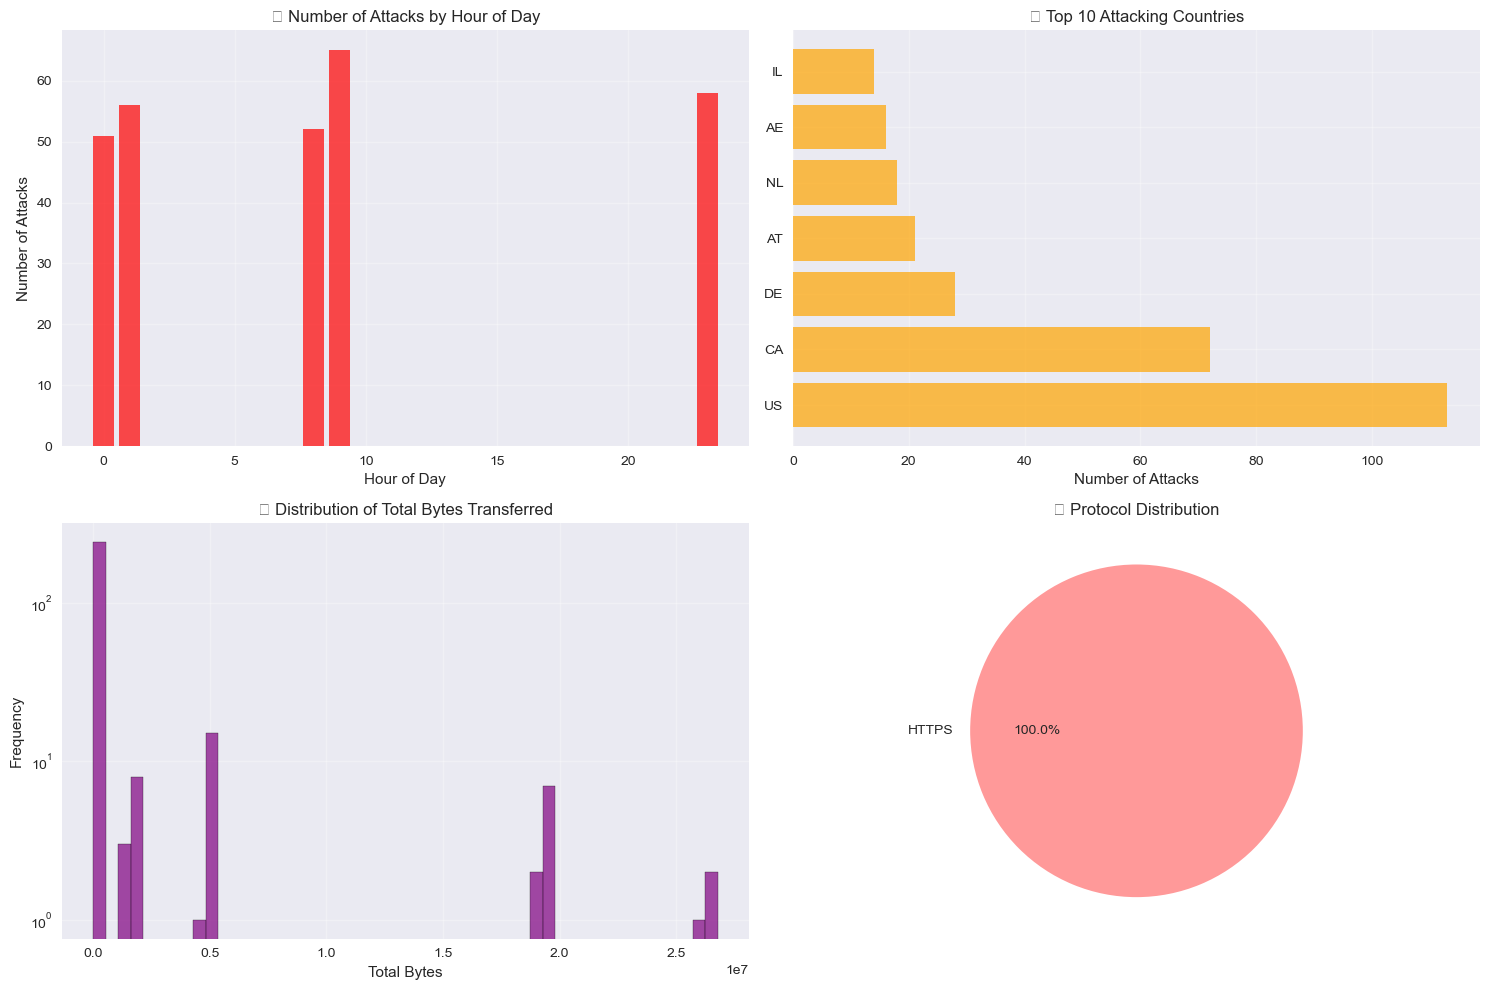

In [4]:
# Step 4: Exploratory Data Analysis (EDA)

print("📊 EXPLORATORY DATA ANALYSIS")
print("=" * 50)

# 4.1 Basic statistics
print("📈 Basic Statistics:")
print(df[['bytes_in', 'bytes_out', 'total_bytes', 'duration_minutes']].describe())

# 4.2 Attack trends over time
plt.figure(figsize=(15, 10))

# Plot 1: Attacks by hour
plt.subplot(2, 2, 1)
hourly_attacks = df.groupby('hour').size()
plt.bar(hourly_attacks.index, hourly_attacks.values, color='red', alpha=0.7)
plt.title('📅 Number of Attacks by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Attacks')
plt.grid(True, alpha=0.3)

# Plot 2: Top attacking countries
plt.subplot(2, 2, 2)
top_countries = df['src_ip_country_code'].value_counts().head(10)
plt.barh(top_countries.index, top_countries.values, color='orange', alpha=0.7)
plt.title('🌍 Top 10 Attacking Countries')
plt.xlabel('Number of Attacks')
plt.grid(True, alpha=0.3)

# Plot 3: Bytes distribution
plt.subplot(2, 2, 3)
plt.hist(df['total_bytes'], bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.title('📦 Distribution of Total Bytes Transferred')
plt.xlabel('Total Bytes')
plt.ylabel('Frequency')
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Plot 4: Protocol distribution
plt.subplot(2, 2, 4)
protocol_counts = df['protocol'].value_counts()
plt.pie(protocol_counts.values, labels=protocol_counts.index, autopct='%1.1f%%', 
        colors=['#ff9999','#66b3ff'])
plt.title('🔒 Protocol Distribution')

plt.tight_layout()
plt.show()


🎯 ADVANCED ATTACK PATTERN ANALYSIS
🔝 Top 15 Attacking IPs:
  165.225.209.4 (CA): 29 attacks, Avg bytes: 32,942
  165.225.26.101 (DE): 28 attacks, Avg bytes: 25,681
  155.91.45.242 (US): 28 attacks, Avg bytes: 11,937,932
  136.226.67.101 (US): 28 attacks, Avg bytes: 53,600
  147.161.131.1 (AT): 21 attacks, Avg bytes: 18,023
  165.225.240.79 (NL): 18 attacks, Avg bytes: 1,131,164
  136.226.77.103 (CA): 17 attacks, Avg bytes: 35,345
  147.161.161.82 (AE): 16 attacks, Avg bytes: 17,154
  165.225.212.255 (CA): 15 attacks, Avg bytes: 43,909
  94.188.248.74 (IL): 14 attacks, Avg bytes: 13,692
  136.226.64.114 (US): 13 attacks, Avg bytes: 60,636
  165.225.33.6 (US): 12 attacks, Avg bytes: 50,350
  136.226.80.97 (US): 11 attacks, Avg bytes: 12,714
  165.225.213.7 (CA): 11 attacks, Avg bytes: 40,189
  165.225.8.79 (US): 6 attacks, Avg bytes: 14,264


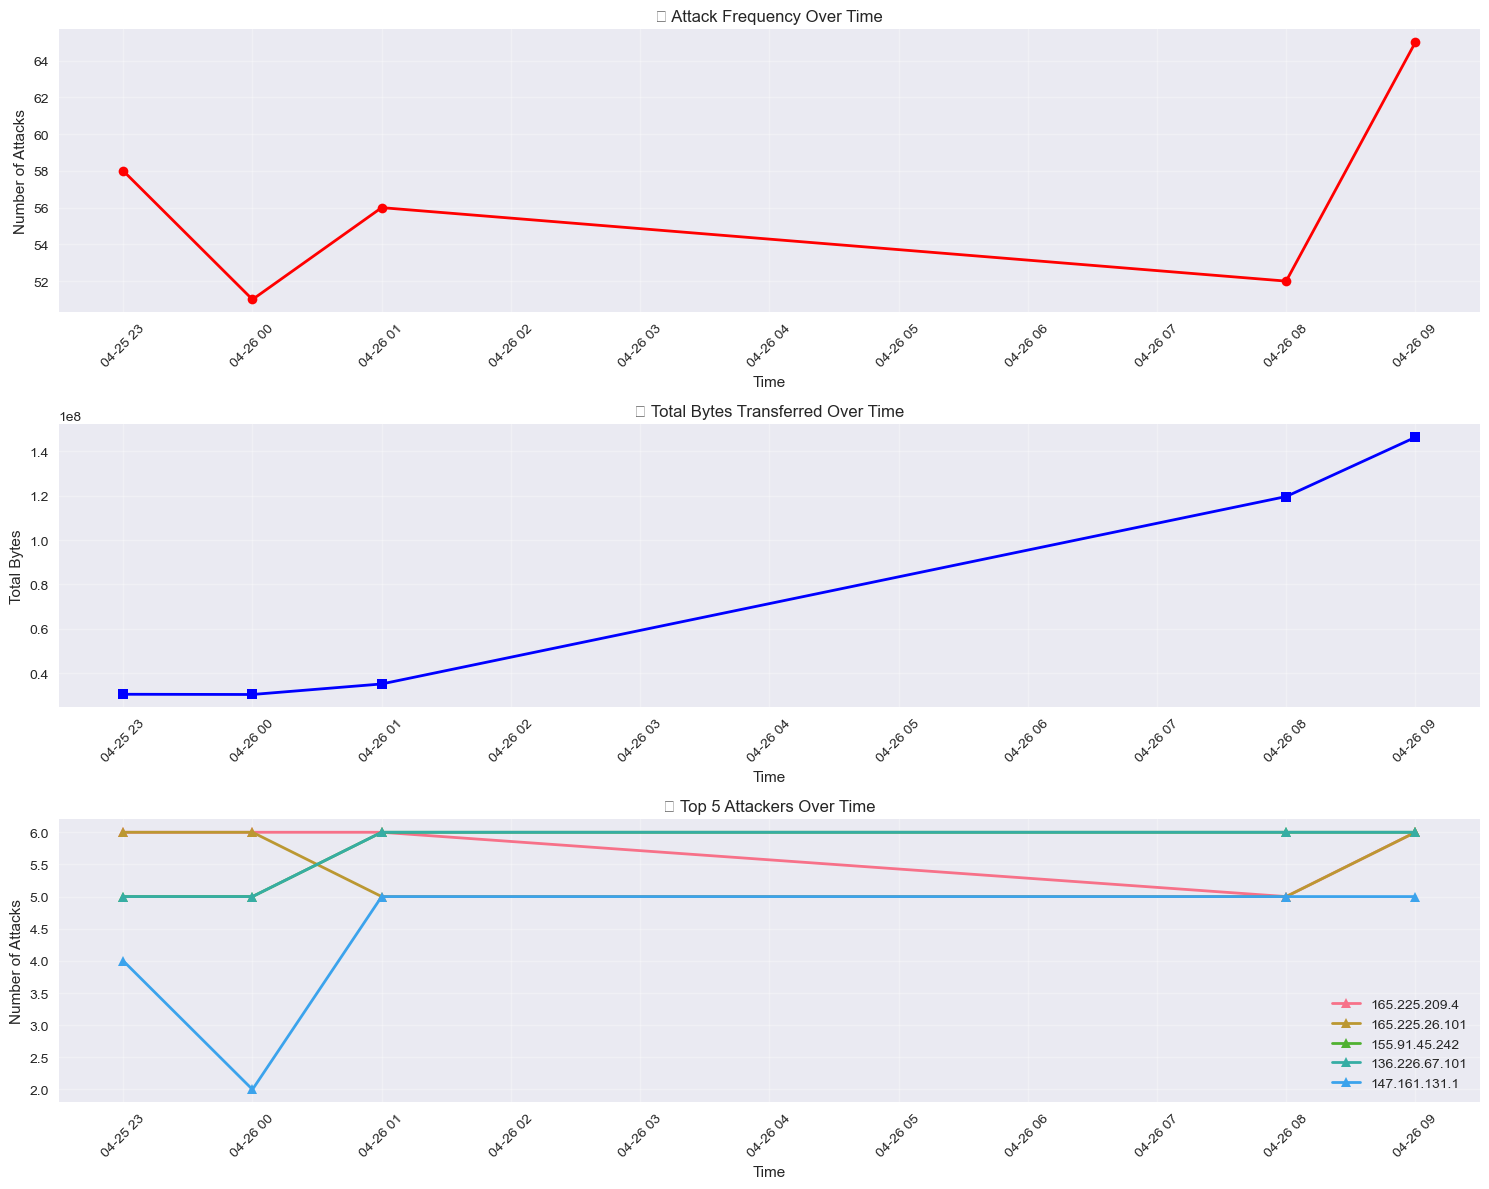

In [5]:
# Step 5: Advanced EDA - Attack Patterns

print("🎯 ADVANCED ATTACK PATTERN ANALYSIS")
print("=" * 50)

# 5.1 Top attacking IPs
top_attackers = df['src_ip'].value_counts().head(15)
print("🔝 Top 15 Attacking IPs:")
for ip, count in top_attackers.items():
    country = df[df['src_ip'] == ip]['src_ip_country_code'].iloc[0]
    avg_bytes = df[df['src_ip'] == ip]['total_bytes'].mean()
    print(f"  {ip} ({country}): {count} attacks, Avg bytes: {avg_bytes:,.0f}")

# 5.2 Time-based attack analysis
plt.figure(figsize=(15, 12))

# Plot 1: Attacks over time
plt.subplot(3, 1, 1)
df['creation_time_hour'] = df['creation_time'].dt.floor('H')
time_series = df.groupby('creation_time_hour').size()
plt.plot(time_series.index, time_series.values, marker='o', linewidth=2, color='red')
plt.title('⏰ Attack Frequency Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 2: Bytes over time
plt.subplot(3, 1, 2)
bytes_time = df.groupby('creation_time_hour')['total_bytes'].sum()
plt.plot(bytes_time.index, bytes_time.values, marker='s', linewidth=2, color='blue')
plt.title('💾 Total Bytes Transferred Over Time')
plt.xlabel('Time')
plt.ylabel('Total Bytes')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Plot 3: Top attackers over time
plt.subplot(3, 1, 3)
top_5_ips = top_attackers.head(5).index
for ip in top_5_ips:
    ip_data = df[df['src_ip'] == ip]
    ip_time_series = ip_data.groupby('creation_time_hour').size()
    plt.plot(ip_time_series.index, ip_time_series.values, marker='^', linewidth=2, label=ip)
plt.title('👥 Top 5 Attackers Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Attacks')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [6]:
# Step 6: Feature Engineering

print("⚙️ FEATURE ENGINEERING")
print("=" * 50)

# Create security-focused features
df['bytes_per_minute'] = df['total_bytes'] / df['duration_minutes']
df['in_out_ratio'] = df['bytes_in'] / (df['bytes_out'] + 1)  # +1 to avoid division by zero

# Create attack intensity score
df['attack_intensity'] = (df['total_bytes'] / df['total_bytes'].max() + 
                         df['duration_minutes'] / df['duration_minutes'].max())

# Create time-based features
df['is_night'] = ((df['hour'] >= 22) | (df['hour'] <= 6)).astype(int)
df['is_peak_hours'] = ((df['hour'] >= 9) & (df['hour'] <= 17)).astype(int)

# Create IP frequency features
ip_frequency = df['src_ip'].value_counts().to_dict()
df['ip_attack_frequency'] = df['src_ip'].map(ip_frequency)

# Create country frequency features
country_frequency = df['src_ip_country_code'].value_counts().to_dict()
df['country_attack_frequency'] = df['src_ip_country_code'].map(country_frequency)

print("✅ Security features created:")
new_features = ['bytes_per_minute', 'in_out_ratio', 'attack_intensity', 
               'is_night', 'is_peak_hours', 'ip_attack_frequency', 'country_attack_frequency']
display(df[new_features].describe())

⚙️ FEATURE ENGINEERING
✅ Security features created:


,bytes_per_minute,in_out_ratio,attack_intensity,is_night,is_peak_hours,ip_attack_frequency,country_attack_frequency
count,2.820000e+02,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,1.283944e+05,4.021574,1.047964,0.585106,0.230496,19.624113,70.758865
std,4.403689e+05,7.948723,0.164507,0.493580,0.421899,8.156860,39.933557
min,1.240000e+01,0.150943,1.000005,0.000000,0.000000,1.000000,14.000000
25%,1.607500e+03,0.502642,1.000601,0.000000,0.000000,14.000000,28.000000
50%,3.288200e+03,1.119070,1.001228,1.000000,0.000000,18.000000,72.000000
75%,5.707750e+03,2.115601,1.002132,1.000000,0.000000,28.000000,113.000000
max,2.676901e+06,55.085959,2.000000,1.000000,1.000000,29.000000,113.000000


🔍 ANOMALY DETECTION WITH ISOLATION FOREST
🎯 Anomaly Detection Results:
Total records: 282
Anomalies detected: 29 (10.3%)


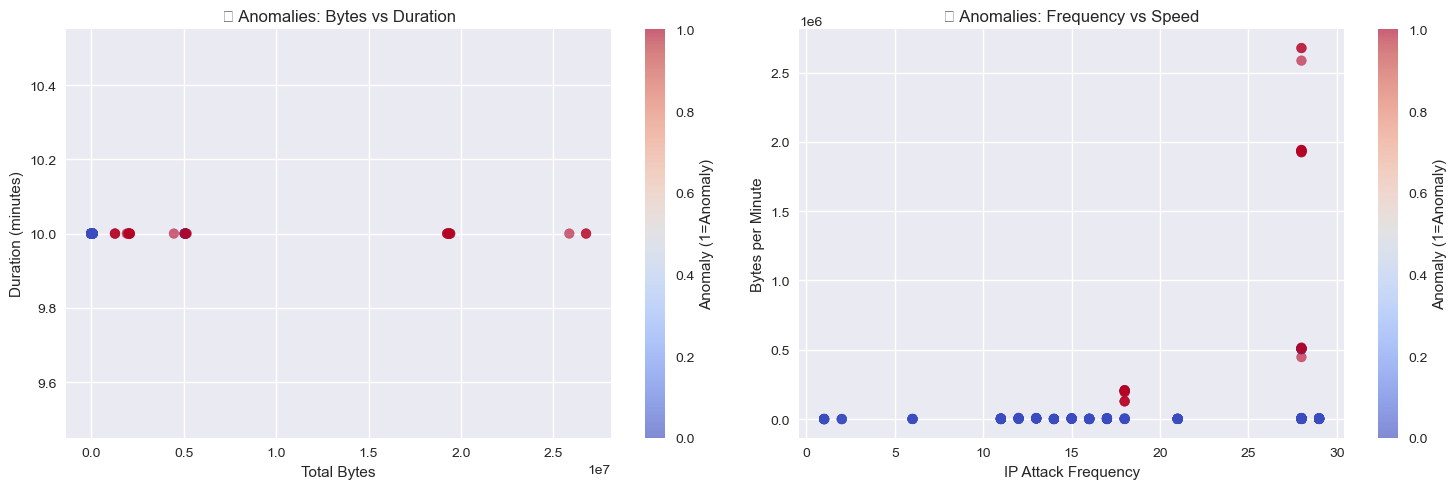

In [7]:
# Step 7: Anomaly Detection with Isolation Forest

print("🔍 ANOMALY DETECTION WITH ISOLATION FOREST")
print("=" * 50)

# Select features for anomaly detection
features_for_anomaly = ['total_bytes', 'duration_minutes', 'bytes_per_minute', 
                       'in_out_ratio', 'ip_attack_frequency', 'attack_intensity']

X = df[features_for_anomaly]

# Handle infinite values
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply Isolation Forest
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.1,  # expecting 10% anomalies
    random_state=42
)

anomaly_predictions = iso_forest.fit_predict(X_scaled)

# Add predictions to dataframe
df['is_anomaly'] = anomaly_predictions
df['is_anomaly'] = df['is_anomaly'].map({1: 0, -1: 1})  # Convert to 0=normal, 1=anomaly

print(f"🎯 Anomaly Detection Results:")
print(f"Total records: {len(df)}")
print(f"Anomalies detected: {df['is_anomaly'].sum()} ({df['is_anomaly'].mean()*100:.1f}%)")

# Visualize anomalies
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.scatter(df['total_bytes'], df['duration_minutes'], 
           c=df['is_anomaly'], cmap='coolwarm', alpha=0.6)
plt.xlabel('Total Bytes')
plt.ylabel('Duration (minutes)')
plt.title('🚨 Anomalies: Bytes vs Duration')
plt.colorbar(label='Anomaly (1=Anomaly)')

plt.subplot(1, 2, 2)
plt.scatter(df['ip_attack_frequency'], df['bytes_per_minute'], 
           c=df['is_anomaly'], cmap='coolwarm', alpha=0.6)
plt.xlabel('IP Attack Frequency')
plt.ylabel('Bytes per Minute')
plt.title('🚨 Anomalies: Frequency vs Speed')
plt.colorbar(label='Anomaly (1=Anomaly)')

plt.tight_layout()
plt.show()

📊 DETAILED ANOMALY ANALYSIS
🔍 Top Anomalous Attacks:


,src_ip,src_ip_country_code,total_bytes,duration_minutes,ip_attack_frequency
279,155.91.45.242,US,26769014,10.0,28
267,155.91.45.242,US,26756789,10.0,28
257,155.91.45.242,US,25855976,10.0,28
176,155.91.45.242,US,19418229,10.0,28
185,155.91.45.242,US,19416469,10.0,28
194,155.91.45.242,US,19383719,10.0,28
169,155.91.45.242,US,19372454,10.0,28
248,155.91.45.242,US,19348604,10.0,28
232,155.91.45.242,US,19330383,10.0,28
211,155.91.45.242,US,19274761,10.0,28



📈 Comparison: Normal vs Anomalous Traffic


,Normal_Mean,Anomaly_Mean,Ratio
total_bytes,231145.252964,1.046871e+07,45.290613
duration_minutes,10.000000,1.000000e+01,1.000000
bytes_per_minute,23114.525296,1.046871e+06,45.290613
in_out_ratio,1.841971,2.303673e+01,12.506564
ip_attack_frequency,19.098814,2.420690e+01,1.267455
attack_intensity,1.008635,1.391076e+00,1.379167


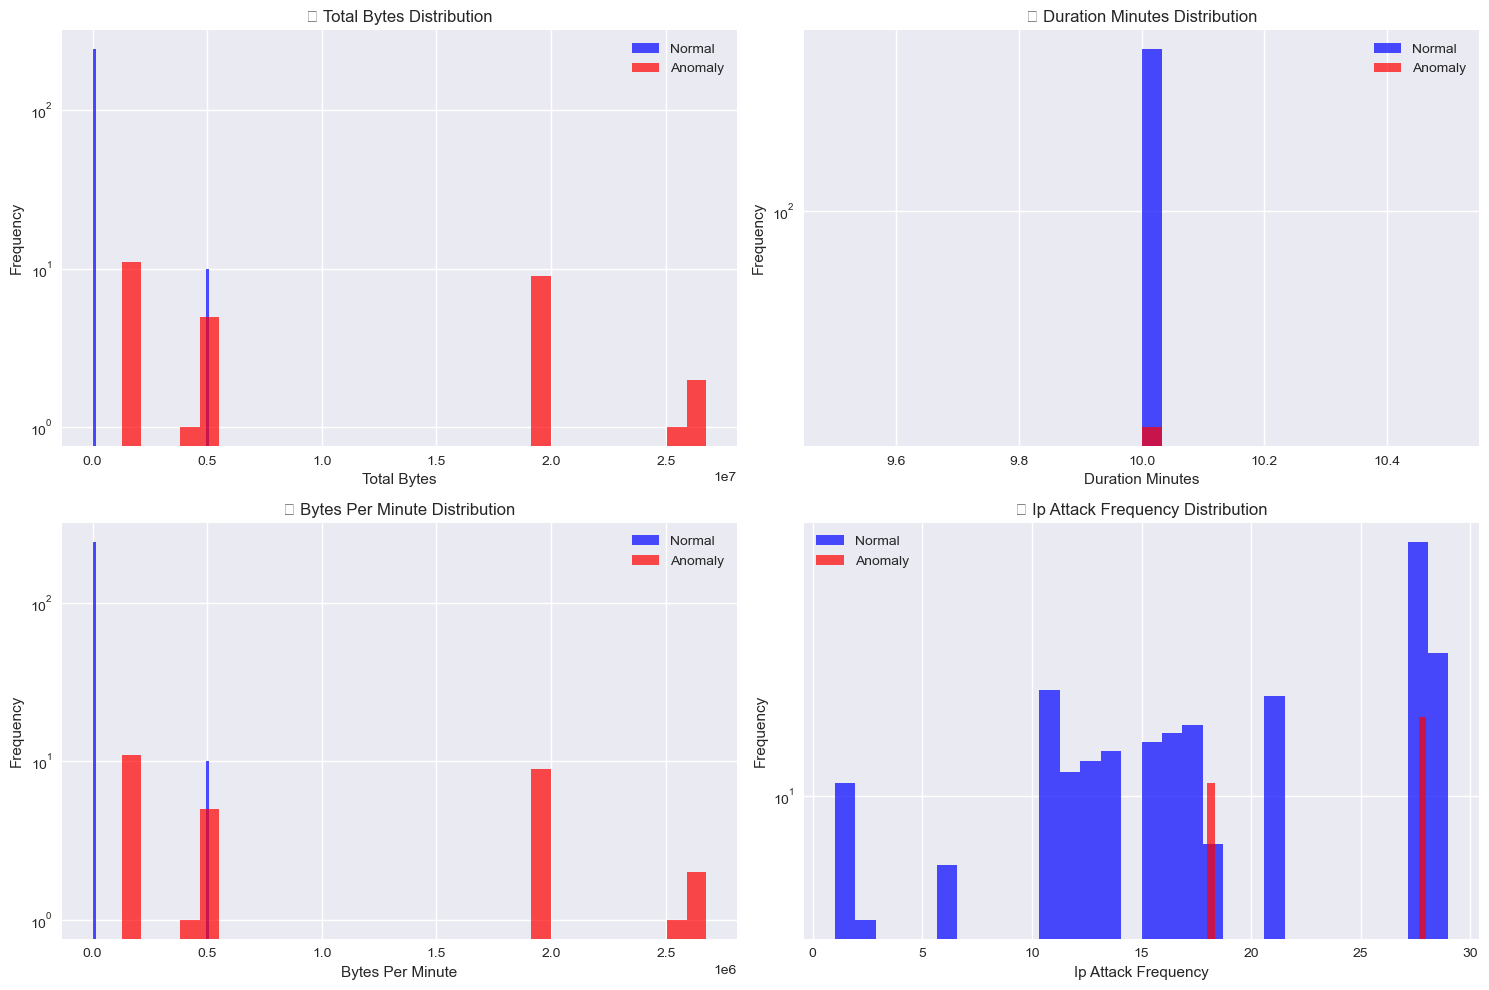

In [8]:
# Step 8: Detailed Anomaly Analysis

print("📊 DETAILED ANOMALY ANALYSIS")
print("=" * 50)

anomalies = df[df['is_anomaly'] == 1]
normal = df[df['is_anomaly'] == 0]

print("🔍 Top Anomalous Attacks:")
top_anomalies = anomalies.nlargest(10, 'total_bytes')[['src_ip', 'src_ip_country_code', 'total_bytes', 
                                                    'duration_minutes', 'ip_attack_frequency']]
display(top_anomalies)

# Compare statistics
print("\n📈 Comparison: Normal vs Anomalous Traffic")
comparison = pd.DataFrame({
    'Normal_Mean': normal[features_for_anomaly].mean(),
    'Anomaly_Mean': anomalies[features_for_anomaly].mean(),
    'Ratio': anomalies[features_for_anomaly].mean() / normal[features_for_anomaly].mean()
})
display(comparison)

# Visualize anomaly characteristics
plt.figure(figsize=(15, 10))

features_to_plot = ['total_bytes', 'duration_minutes', 'bytes_per_minute', 'ip_attack_frequency']

for i, feature in enumerate(features_to_plot, 1):
    plt.subplot(2, 2, i)
    plt.hist(normal[feature], bins=30, alpha=0.7, label='Normal', color='blue')
    plt.hist(anomalies[feature], bins=30, alpha=0.7, label='Anomaly', color='red')
    plt.xlabel(feature.replace('_', ' ').title())
    plt.ylabel('Frequency')
    plt.legend()
    plt.yscale('log')
    plt.title(f'📊 {feature.replace("_", " ").title()} Distribution')

plt.tight_layout()
plt.show()

🌐 NETWORK ANALYSIS
Network Statistics:
Nodes: 29
Edges: 28
Average Degree: 1.93

🔝 Top 10 Most Connected Attackers:
  147.161.161.82 (AE): 0.0357
  165.225.33.6 (US): 0.0357
  165.225.212.255 (CA): 0.0357
  136.226.64.114 (US): 0.0357
  165.225.240.79 (NL): 0.0357
  136.226.77.103 (CA): 0.0357
  165.225.26.101 (DE): 0.0357
  155.91.45.242 (US): 0.0357
  165.225.209.4 (CA): 0.0357


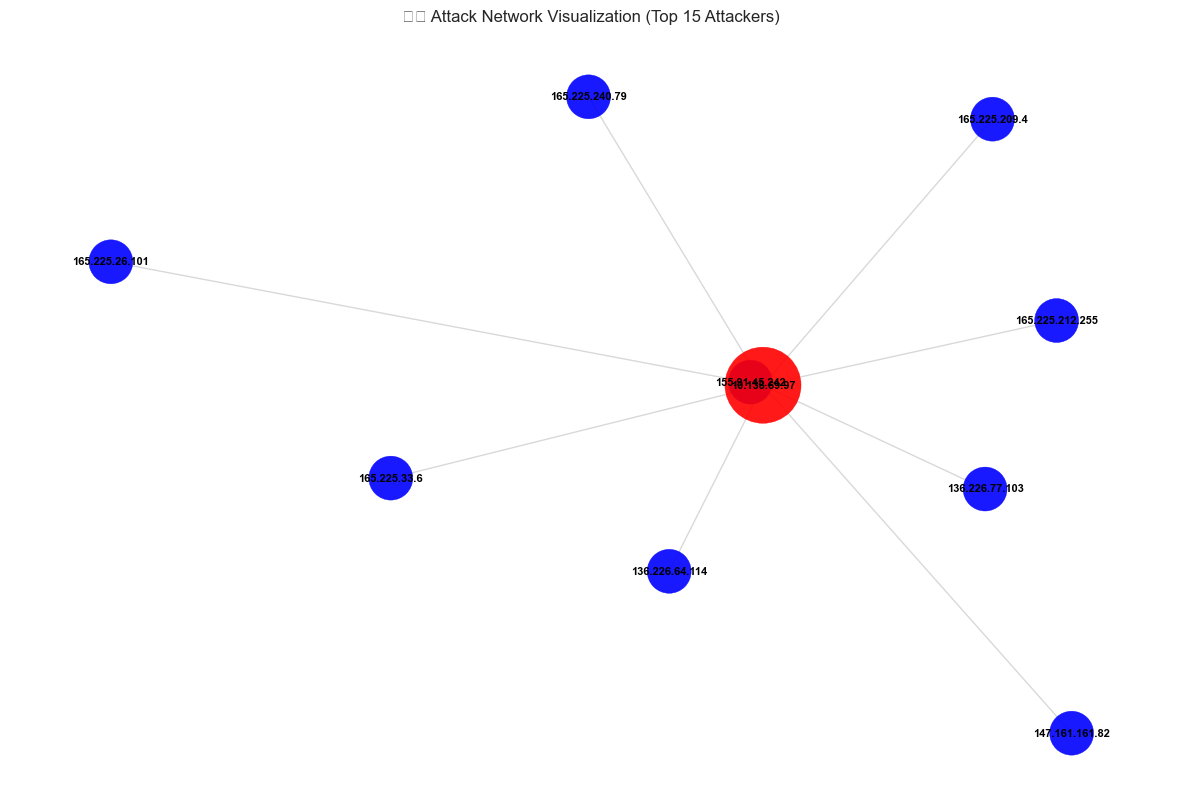

In [9]:
# Step 9: Network Analysis

print("🌐 NETWORK ANALYSIS")
print("=" * 50)

# Create network graph
G = nx.Graph()

# Add nodes and edges
for _, row in df.iterrows():
    G.add_node(row['src_ip'], type='attacker', country=row['src_ip_country_code'])
    G.add_node(row['dst_ip'], type='target')
    G.add_edge(row['src_ip'], row['dst_ip'], 
              weight=row['total_bytes'], 
              time=row['creation_time'])

print(f"Network Statistics:")
print(f"Nodes: {G.number_of_nodes()}")
print(f"Edges: {G.number_of_edges()}")
print(f"Average Degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")

# Analyze network centrality
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Get top central nodes
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
top_betweenness = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:10]

print("\n🔝 Top 10 Most Connected Attackers:")
for ip, centrality in top_degree:
    if ip != '10.138.69.97':  # Skip the target IP
        country = df[df['src_ip'] == ip]['src_ip_country_code'].iloc[0] if ip in df['src_ip'].values else 'Unknown'
        print(f"  {ip} ({country}): {centrality:.4f}")

# Visualize network (simplified)
plt.figure(figsize=(15, 10))

# Create subgraph of top attackers
top_attackers_list = [ip for ip, _ in top_degree[:15] if ip != '10.138.69.97']
top_attackers_list.append('10.138.69.97')  # Add target
subgraph = G.subgraph(top_attackers_list)

# Create layout
pos = nx.spring_layout(subgraph, k=3, iterations=50)

# Draw network
node_colors = ['red' if node == '10.138.69.97' else 'blue' for node in subgraph.nodes()]
node_sizes = [3000 if node == '10.138.69.97' else 1000 for node in subgraph.nodes()]

nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=node_sizes, alpha=0.9)
nx.draw_networkx_edges(subgraph, pos, alpha=0.3, edge_color='gray')
nx.draw_networkx_labels(subgraph, pos, font_size=8, font_weight='bold')

plt.title('🕸️ Attack Network Visualization (Top 15 Attackers)')
plt.axis('off')
plt.show()

🌍 GEOGRAPHIC ATTACK ANALYSIS
📊 Top Countries by Attack Volume:


,attack_count,total_bytes,duration_minutes,bytes_per_minute,anomaly_count,anomaly_rate
src_ip_country_code,,,,,,
US,113,337490782,10.0,298664.408850,18,0.159292
CA,72,2656898,10.0,3690.136111,0,0.000000
DE,28,719080,10.0,2568.142857,0,0.000000
AT,21,378482,10.0,1802.295238,0,0.000000
NL,18,20360948,10.0,113116.377778,11,0.611111
AE,16,274466,10.0,1715.412500,0,0.000000
IL,14,191688,10.0,1369.200000,0,0.000000


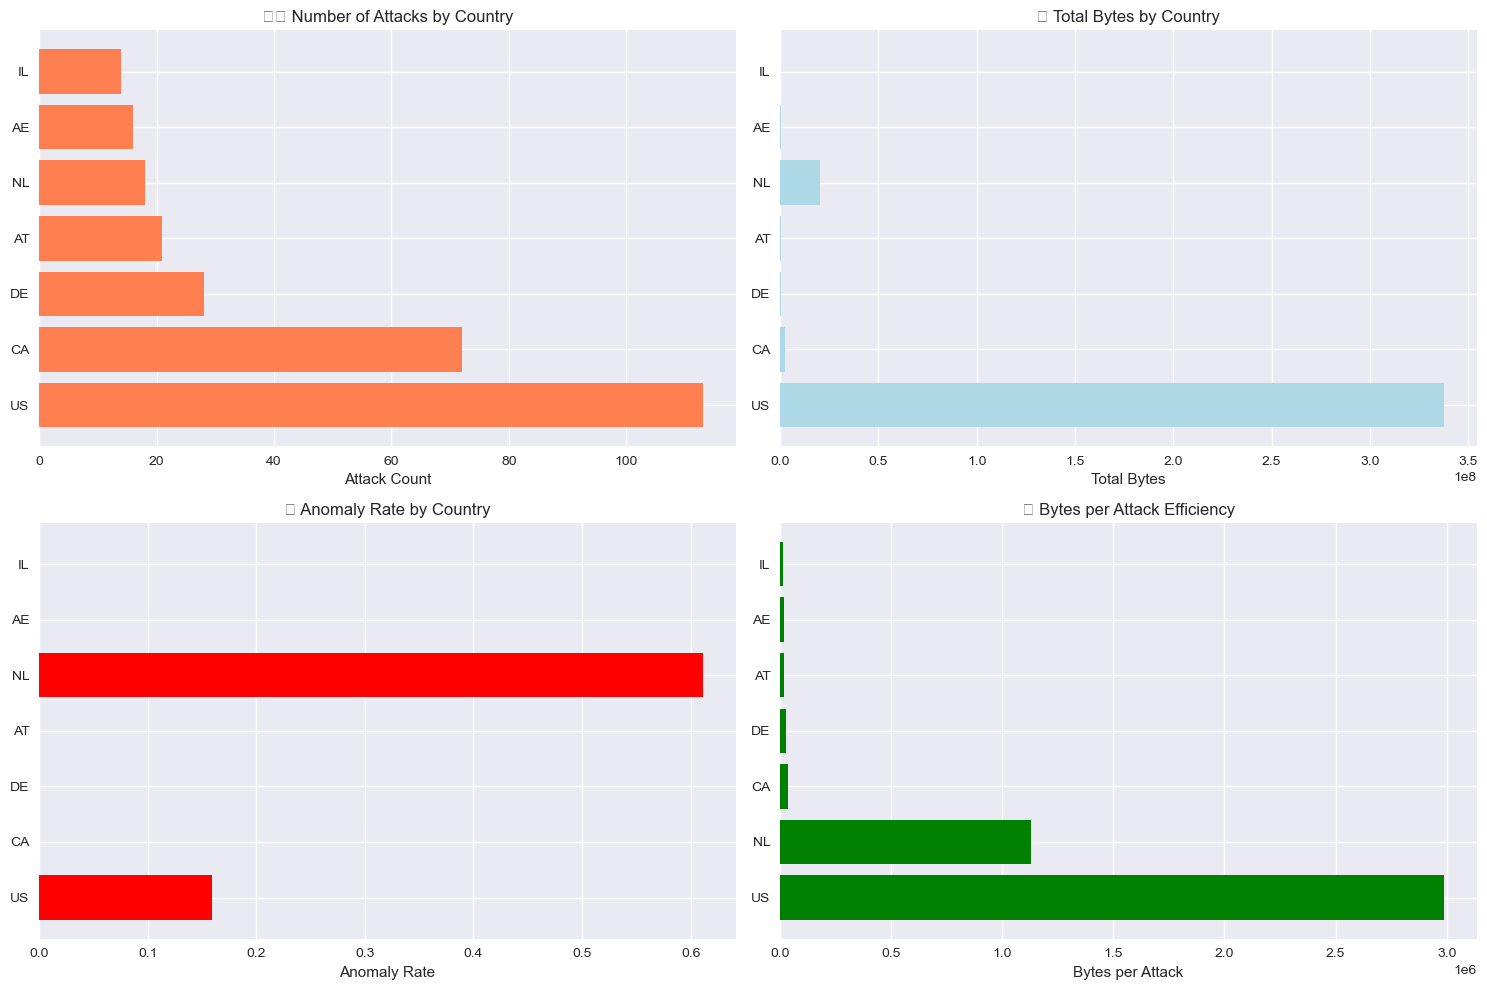

In [10]:
# Step 10: Geographic Analysis

print("🌍 GEOGRAPHIC ATTACK ANALYSIS")
print("=" * 50)

# Country-based analysis
country_analysis = df.groupby('src_ip_country_code').agg({
    'src_ip': 'count',
    'total_bytes': 'sum',
    'duration_minutes': 'mean',
    'bytes_per_minute': 'mean',
    'is_anomaly': 'sum'
}).rename(columns={
    'src_ip': 'attack_count',
    'is_anomaly': 'anomaly_count'
})

country_analysis['anomaly_rate'] = country_analysis['anomaly_count'] / country_analysis['attack_count']
country_analysis = country_analysis.sort_values('attack_count', ascending=False)

print("📊 Top Countries by Attack Volume:")
display(country_analysis.head(10))

# Visualize geographic distribution
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
top_countries_plot = country_analysis.head(10)
plt.barh(top_countries_plot.index, top_countries_plot['attack_count'], color='coral')
plt.title('🇺🇳 Number of Attacks by Country')
plt.xlabel('Attack Count')

plt.subplot(2, 2, 2)
plt.barh(top_countries_plot.index, top_countries_plot['total_bytes'], color='lightblue')
plt.title('💾 Total Bytes by Country')
plt.xlabel('Total Bytes')

plt.subplot(2, 2, 3)
plt.barh(top_countries_plot.index, top_countries_plot['anomaly_rate'], color='red')
plt.title('🚨 Anomaly Rate by Country')
plt.xlabel('Anomaly Rate')
                                       
plt.subplot(2, 2, 4)
# Bytes per attack efficiency
country_analysis['bytes_per_attack'] = country_analysis['total_bytes'] / country_analysis['attack_count']
top_efficient = country_analysis.nlargest(10, 'bytes_per_attack')
plt.barh(top_efficient.index, top_efficient['bytes_per_attack'], color='green')
plt.title('⚡ Bytes per Attack Efficiency')
plt.xlabel('Bytes per Attack')

plt.tight_layout()
plt.show()

🤖 MACHINE LEARNING MODEL COMPARISON
📊 Random Forest Performance (using Isolation Forest as ground truth):
Accuracy: 1.000
Precision: 1.000
Recall: 1.000
F1-Score: 1.000

🔝 Feature Importance:


,feature,importance
0,total_bytes,0.277536
2,bytes_per_minute,0.273019
3,in_out_ratio,0.233935
6,attack_intensity,0.162030
7,is_night,0.027739
4,ip_attack_frequency,0.012340
5,country_attack_frequency,0.010605
8,is_peak_hours,0.002797
1,duration_minutes,0.000000


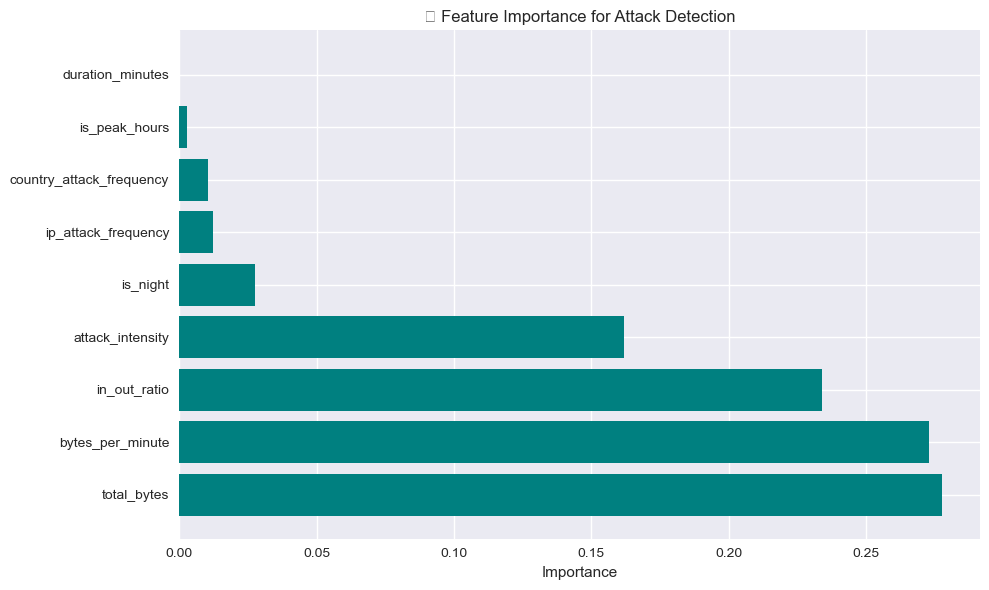

In [11]:
# Step 11: Machine Learning Model Comparison

print("🤖 MACHINE LEARNING MODEL COMPARISON")
print("=" * 50)

# Since we don't have true labels, we'll use the Isolation Forest results as pseudo-labels
# and compare with another algorithm

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Prepare features for supervised learning (using anomaly detection results as target)
ml_features = ['total_bytes', 'duration_minutes', 'bytes_per_minute', 
              'in_out_ratio', 'ip_attack_frequency', 'country_attack_frequency',
              'attack_intensity', 'is_night', 'is_peak_hours']

X_ml = df[ml_features]
y_ml = df['is_anomaly']  # From our Isolation Forest

# Handle any infinite values
X_ml = X_ml.replace([np.inf, -np.inf], np.nan).fillna(0)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_ml, y_ml, test_size=0.3, random_state=42, stratify=y_ml
)

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred_rf)
precision = precision_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf)
f1 = f1_score(y_test, y_pred_rf)

print("📊 Random Forest Performance (using Isolation Forest as ground truth):")
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'feature': ml_features,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n🔝 Feature Importance:")
display(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='teal')
plt.title('📊 Feature Importance for Attack Detection')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

In [12]:
# Step 12: Security Reporting and Insights

print("📋 SECURITY INCIDENT REPORT")
print("=" * 60)
print(f"Report Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

# Executive Summary
total_attacks = len(df)
unique_attackers = df['src_ip'].nunique()
unique_countries = df['src_ip_country_code'].nunique()
total_data_transferred = df['total_bytes'].sum() / (1024**3)  # Convert to GB
anomaly_percentage = df['is_anomaly'].mean() * 100

print("\n📈 EXECUTIVE SUMMARY")
print(f"• Total Attack Events: {total_attacks:,}")
print(f"• Unique Attackers: {unique_attackers}")
print(f"• Countries Involved: {unique_countries}")
print(f"• Data Transferred: {total_data_transferred:.2f} GB")
print(f"• Anomaly Rate: {anomaly_percentage:.1f}%")

# Top Threats
print("\n🚨 TOP SECURITY THREATS")

# Most aggressive attackers
top_5_attackers = df.groupby('src_ip').agg({
    'src_ip_country_code': 'first',
    'total_bytes': 'sum',
    'duration_minutes': 'sum',
    'is_anomaly': 'sum'
}).nlargest(5, 'total_bytes')

print("\n🔝 Top 5 Most Dangerous Attackers:")
for ip, data in top_5_attackers.iterrows():
    print(f"  IP: {ip} ({data['src_ip_country_code']})")
    print(f"    Total Bytes: {data['total_bytes']:,.0f}")
    print(f"    Total Duration: {data['duration_minutes']:.1f} min")
    print(f"    Anomaly Events: {data['is_anomaly']}")

# Time-based insights
peak_attack_hour = df['hour'].value_counts().idxmax()
night_attack_ratio = df['is_night'].mean() * 100

print(f"\n⏰ TIMING INSIGHTS:")
print(f"• Peak Attack Hour: {peak_attack_hour}:00")
print(f"• Night Attacks: {night_attack_ratio:.1f}%")

# Country risk assessment
high_risk_countries = country_analysis[country_analysis['anomaly_rate'] > 0.2]
print(f"\n🌍 HIGH-RISK COUNTRIES (anomaly rate > 20%):")
for country in high_risk_countries.index:
    rate = high_risk_countries.loc[country, 'anomaly_rate'] * 100
    print(f"  {country}: {rate:.1f}% anomaly rate")

# Recommendations
print("\n🛡️ SECURITY RECOMMENDATIONS:")
print("1. 🔒 Block IPs with high anomaly scores and frequent attacks")
print("2. 🌍 Implement geo-blocking for high-risk countries")
print("3. ⏰ Increase monitoring during peak attack hours")
print("4. 📊 Set up alerts for high byte-per-minute transfers")
print("5. 🔄 Review WAF rules for suspicious traffic patterns")

print("\n" + "=" * 60)
print("✅ SECURITY ANALYSIS COMPLETE")

📋 SECURITY INCIDENT REPORT
Report Generated: 2025-11-29 11:40:17

📈 EXECUTIVE SUMMARY
• Total Attack Events: 282
• Unique Attackers: 28
• Countries Involved: 7
• Data Transferred: 0.34 GB
• Anomaly Rate: 10.3%

🚨 TOP SECURITY THREATS

🔝 Top 5 Most Dangerous Attackers:
  IP: 155.91.45.242 (US)
    Total Bytes: 334,262,106
    Total Duration: 280.0 min
    Anomaly Events: 18
  IP: 165.225.240.79 (NL)
    Total Bytes: 20,360,948
    Total Duration: 180.0 min
    Anomaly Events: 11
  IP: 136.226.67.101 (US)
    Total Bytes: 1,500,797
    Total Duration: 280.0 min
    Anomaly Events: 0
  IP: 165.225.209.4 (CA)
    Total Bytes: 955,306
    Total Duration: 290.0 min
    Anomaly Events: 0
  IP: 136.226.64.114 (US)
    Total Bytes: 788,268
    Total Duration: 130.0 min
    Anomaly Events: 0

⏰ TIMING INSIGHTS:
• Peak Attack Hour: 9:00
• Night Attacks: 58.5%

🌍 HIGH-RISK COUNTRIES (anomaly rate > 20%):
  NL: 61.1% anomaly rate

🛡️ SECURITY RECOMMENDATIONS:
1. 🔒 Block IPs with high anomaly scores

In [13]:
# Step 13: Export Results

print("💾 EXPORTING RESULTS")
print("=" * 50)

# Create summary dataframe
security_summary = df.groupby('src_ip').agg({
    'src_ip_country_code': 'first',
    'total_bytes': ['sum', 'mean', 'max'],
    'duration_minutes': ['sum', 'mean'],
    'bytes_per_minute': 'mean',
    'is_anomaly': 'sum',
    'hour': 'count'
}).round(2)

# Flatten column names
security_summary.columns = ['_'.join(col).strip() for col in security_summary.columns.values]
security_summary = security_summary.rename(columns={'hour_count': 'attack_count'})
security_summary = security_summary.sort_values('total_bytes_sum', ascending=False)

# Save to CSV
security_summary.to_csv('security_analysis_results.csv')
df.to_csv('full_dataset_with_anomalies.csv', index=False)

print("✅ Results exported successfully!")
print(f"• Security summary: security_analysis_results.csv")
print(f"• Full dataset with anomalies: full_dataset_with_anomalies.csv")

# Final summary
print(f"\n🎯 ANALYSIS COMPLETE - KEY FINDINGS:")
print(f"• Analyzed {len(df):,} security events")
print(f"• Identified {df['is_anomaly'].sum():,} anomalous activities")
print(f"• Top attacker: {security_summary.index[0]}")
print(f"• Most active country: {df['src_ip_country_code'].value_counts().index[0]}")
print(f"• Peak data transfer: {df['total_bytes'].max():,.0f} bytes")

💾 EXPORTING RESULTS
✅ Results exported successfully!
• Security summary: security_analysis_results.csv
• Full dataset with anomalies: full_dataset_with_anomalies.csv

🎯 ANALYSIS COMPLETE - KEY FINDINGS:
• Analyzed 282 security events
• Identified 29 anomalous activities
• Top attacker: 155.91.45.242
• Most active country: US
• Peak data transfer: 26,769,014 bytes
